# Notebook 2: Text Chunking and Preprocessing

## Purpose
This notebook processes the extracted text from PDFs and splits it into semantic chunks suitable for embedding and retrieval.

## Process
1. Load extracted text data from Notebook 1
2. Clean and preprocess text (remove extra whitespace, special characters)
3. Split text into chunks with configurable size and overlap
4. Preserve metadata (book title, chapter, page number) for each chunk
5. Create unique IDs for each chunk
6. Save chunked data for embedding generation

## Output
- Chunked text with metadata (JSON format)
- Statistics on chunk distribution
- Ready for embedding generation in Notebook 3

In [1]:
# Import required libraries
import os
import json
import re
from pathlib import Path
from typing import List, Dict, Any
from tqdm import tqdm
import hashlib
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken

In [2]:
# Configuration: Set up paths and chunking parameters
BASE_DIR = Path(r"d:\AI Book RAG")
EXTRACTED_DIR = BASE_DIR / "data" / "extracted"
CHUNKS_DIR = BASE_DIR / "data" / "chunks"

# Create output directory
CHUNKS_DIR.mkdir(parents=True, exist_ok=True)

# Chunking parameters (configurable)
CHUNK_SIZE = 1000  # Characters per chunk
CHUNK_OVERLAP = 200  # Overlap between chunks to maintain context
MIN_CHUNK_SIZE = 100  # Minimum chunk size to keep

print(f"Extracted Data Directory: {EXTRACTED_DIR}")
print(f"Chunks Output Directory: {CHUNKS_DIR}")
print(f"\nChunking Configuration:")
print(f"  - Chunk Size: {CHUNK_SIZE} characters")
print(f"  - Chunk Overlap: {CHUNK_OVERLAP} characters")
print(f"  - Minimum Chunk Size: {MIN_CHUNK_SIZE} characters")

Extracted Data Directory: d:\AI Book RAG\data\extracted
Chunks Output Directory: d:\AI Book RAG\data\chunks

Chunking Configuration:
  - Chunk Size: 1000 characters
  - Chunk Overlap: 200 characters
  - Minimum Chunk Size: 100 characters


In [3]:
# Load extracted data from Notebook 1
combined_file = EXTRACTED_DIR / "all_books_combined.json"

print(f"Loading extracted data from: {combined_file}")

with open(combined_file, 'r', encoding='utf-8') as f:
    all_books_data = json.load(f)

print(f"✓ Loaded data for {len(all_books_data)} books")

# Calculate total pages
total_pages = sum(book['total_pages'] for book in all_books_data)
print(f"✓ Total pages to process: {total_pages}")

Loading extracted data from: d:\AI Book RAG\data\extracted\all_books_combined.json
✓ Loaded data for 6 books
✓ Total pages to process: 3051


In [4]:
# Helper function: Clean text
def clean_text(text: str) -> str:
    """
    Clean and normalize text content.
    - Remove excessive whitespace
    - Normalize line breaks
    - Remove special characters that may interfere with processing
    """
    # Replace multiple spaces with single space
    text = re.sub(r' +', ' ', text)
    
    # Replace multiple newlines with double newline (paragraph separator)
    text = re.sub(r'\n\s*\n+', '\n\n', text)
    
    # Remove leading/trailing whitespace from each line
    lines = [line.strip() for line in text.split('\n')]
    text = '\n'.join(lines)
    
    # Remove page numbers that appear alone on a line (common in PDFs)
    text = re.sub(r'^\d+\s*$', '', text, flags=re.MULTILINE)
    
    # Remove excessive whitespace again after cleaning
    text = re.sub(r'\n\s*\n+', '\n\n', text)
    
    return text.strip()

In [5]:
# Helper function: Generate unique chunk ID
def generate_chunk_id(book_title: str, page_num: int, chunk_index: int) -> str:
    """
    Generate a unique identifier for a text chunk.
    Format: hash of book_title + page number + chunk index
    """
    book_hash = hashlib.md5(book_title.encode()).hexdigest()[:8]
    return f"{book_hash}_p{page_num}_c{chunk_index}"

In [6]:
# Helper function: Count tokens (for monitoring)
def count_tokens(text: str, model: str = "gpt-3.5-turbo") -> int:
    """
    Count the number of tokens in a text string.
    Useful for monitoring chunk sizes in token terms.
    """
    try:
        encoding = tiktoken.encoding_for_model(model)
        return len(encoding.encode(text))
    except:
        # Fallback: rough estimate (1 token ≈ 4 characters)
        return len(text) // 4

In [7]:
# Initialize text splitter using LangChain
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    length_function=len,
    separators=[
        "\n\n",  # Paragraph breaks (highest priority)
        "\n",    # Line breaks
        ". ",    # Sentence breaks
        ", ",    # Clause breaks
        " ",     # Word breaks
        ""       # Character breaks (last resort)
    ]
)

print("✓ Text splitter initialized with RecursiveCharacterTextSplitter")
print(f"  Separators: {text_splitter._separators}")

✓ Text splitter initialized with RecursiveCharacterTextSplitter
  Separators: ['\n\n', '\n', '. ', ', ', ' ', '']


In [8]:
# Main function: Process and chunk text from all books
def create_chunks_from_books(books_data: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Process all books and create chunks with metadata.
    
    Args:
        books_data: List of book data dictionaries from Notebook 1
    
    Returns:
        List of chunk dictionaries with text and metadata
    """
    all_chunks = []
    chunk_global_index = 0
    
    # Process each book
    for book_data in books_data:
        book_title = book_data['book_title']
        pages = book_data['pages']
        
        print(f"\nProcessing: {book_title}")
        print(f"Pages: {len(pages)}")
        
        book_chunks = []
        
        # Process each page
        for page_data in tqdm(pages, desc=f"Chunking {book_title}"):
            # Clean the text
            cleaned_text = clean_text(page_data['text'])
            
            # Skip if text is too short after cleaning
            if len(cleaned_text) < MIN_CHUNK_SIZE:
                continue
            
            # Split text into chunks
            text_chunks = text_splitter.split_text(cleaned_text)
            
            # Create metadata for each chunk
            for chunk_index, chunk_text in enumerate(text_chunks):
                # Skip very small chunks
                if len(chunk_text) < MIN_CHUNK_SIZE:
                    continue
                
                # Generate unique chunk ID
                chunk_id = generate_chunk_id(
                    book_title, 
                    page_data['page_number'], 
                    chunk_index
                )
                
                # Count tokens for monitoring
                token_count = count_tokens(chunk_text)
                
                # Create chunk object with metadata
                chunk = {
                    "chunk_id": chunk_id,
                    "global_index": chunk_global_index,
                    "book_title": book_title,
                    "chapter": page_data['chapter'],
                    "page_number": page_data['page_number'],
                    "chunk_index": chunk_index,
                    "text": chunk_text,
                    "char_count": len(chunk_text),
                    "word_count": len(chunk_text.split()),
                    "token_count": token_count,
                    "citation": f"[{book_title}, {page_data['chapter']}, Page {page_data['page_number']}]"
                }
                
                book_chunks.append(chunk)
                all_chunks.append(chunk)
                chunk_global_index += 1
        
        print(f"✓ Created {len(book_chunks)} chunks from {book_title}")
    
    return all_chunks

In [9]:
# Execute chunking process
print("Starting chunking process...\n")
print("="*80)

all_chunks = create_chunks_from_books(all_books_data)

print("\n" + "="*80)
print(f"Chunking complete!")
print(f"Total chunks created: {len(all_chunks)}")
print("="*80)

Starting chunking process...


Processing: AI Engineering
Pages: 529


Chunking AI Engineering: 100%|██████████| 529/529 [00:03<00:00, 135.94it/s]


✓ Created 1487 chunks from AI Engineering

Processing: Applied-Machine-Learning-and-AI-for-Engineers
Pages: 661


Chunking Applied-Machine-Learning-and-AI-for-Engineers: 100%|██████████| 661/661 [00:00<00:00, 1339.77it/s]


✓ Created 1088 chunks from Applied-Machine-Learning-and-AI-for-Engineers

Processing: Hands-On Large Language Models Language Understanding and Generation
Pages: 413


Chunking Hands-On Large Language Models Language Understanding and Generation: 100%|██████████| 413/413 [00:00<00:00, 1618.90it/s]


✓ Created 886 chunks from Hands-On Large Language Models Language Understanding and Generation

Processing: Hands-On Machine Learning with Scikit-Learn and PyTorch (Second Early Release)
Pages: 532


Chunking Hands-On Machine Learning with Scikit-Learn and PyTorch (Second Early Release): 100%|██████████| 532/532 [00:00<00:00, 1704.65it/s]


✓ Created 1202 chunks from Hands-On Machine Learning with Scikit-Learn and PyTorch (Second Early Release)

Processing: LLM Engineers Handbook
Pages: 513


Chunking LLM Engineers Handbook: 100%|██████████| 513/513 [00:00<00:00, 1653.75it/s]


✓ Created 1235 chunks from LLM Engineers Handbook

Processing: NLP with Transformer models
Pages: 403


Chunking NLP with Transformer models: 100%|██████████| 403/403 [00:00<00:00, 1216.37it/s]

✓ Created 1052 chunks from NLP with Transformer models

Chunking complete!
Total chunks created: 6950


In [10]:
# Save chunked data to JSON
print("\nSaving chunked data...")

# Save all chunks to a single file
chunks_file = CHUNKS_DIR / "all_chunks.json"
with open(chunks_file, 'w', encoding='utf-8') as f:
    json.dump(all_chunks, f, indent=2, ensure_ascii=False)
print(f"✓ Saved: {chunks_file.name}")

# Save chunks by book (for easier management)
chunks_by_book = {}
for chunk in all_chunks:
    book_title = chunk['book_title']
    if book_title not in chunks_by_book:
        chunks_by_book[book_title] = []
    chunks_by_book[book_title].append(chunk)

# Save each book's chunks separately
for book_title, chunks in chunks_by_book.items():
    book_title_safe = re.sub(r'[^a-zA-Z0-9\s]', '', book_title)
    book_title_safe = '_'.join(book_title_safe.split())
    
    book_chunks_file = CHUNKS_DIR / f"{book_title_safe}_chunks.json"
    with open(book_chunks_file, 'w', encoding='utf-8') as f:
        json.dump(chunks, f, indent=2, ensure_ascii=False)
    
    print(f"✓ Saved: {book_chunks_file.name} ({len(chunks)} chunks)")

print("\nAll chunked data saved successfully!")


Saving chunked data...
✓ Saved: all_chunks.json
✓ Saved: AI_Engineering_chunks.json (1487 chunks)
✓ Saved: AppliedMachineLearningandAIforEngineers_chunks.json (1088 chunks)
✓ Saved: HandsOn_Large_Language_Models_Language_Understanding_and_Generation_chunks.json (886 chunks)
✓ Saved: HandsOn_Machine_Learning_with_ScikitLearn_and_PyTorch_Second_Early_Release_chunks.json (1202 chunks)
✓ Saved: LLM_Engineers_Handbook_chunks.json (1235 chunks)
✓ Saved: NLP_with_Transformer_models_chunks.json (1052 chunks)

All chunked data saved successfully!


In [11]:
# Generate and display statistics
print("\n" + "="*80)
print("CHUNKING STATISTICS")
print("="*80)

# Overall statistics
total_chunks = len(all_chunks)
total_chars = sum(chunk['char_count'] for chunk in all_chunks)
total_words = sum(chunk['word_count'] for chunk in all_chunks)
total_tokens = sum(chunk['token_count'] for chunk in all_chunks)

avg_chars = total_chars / total_chunks if total_chunks > 0 else 0
avg_words = total_words / total_chunks if total_chunks > 0 else 0
avg_tokens = total_tokens / total_chunks if total_chunks > 0 else 0

print(f"\nOverall Statistics:")
print(f"  Total Chunks: {total_chunks:,}")
print(f"  Total Characters: {total_chars:,}")
print(f"  Total Words: {total_words:,}")
print(f"  Total Tokens (estimated): {total_tokens:,}")
print(f"\nAverage per Chunk:")
print(f"  Characters: {avg_chars:.1f}")
print(f"  Words: {avg_words:.1f}")
print(f"  Tokens: {avg_tokens:.1f}")


CHUNKING STATISTICS

Overall Statistics:
  Total Chunks: 6,950
  Total Characters: 5,504,220
  Total Words: 847,841
  Total Tokens (estimated): 1,265,328

Average per Chunk:
  Characters: 792.0
  Words: 122.0
  Tokens: 182.1


In [12]:
# Statistics by book
book_stats = []
for book_title, chunks in chunks_by_book.items():
    book_chars = sum(chunk['char_count'] for chunk in chunks)
    book_words = sum(chunk['word_count'] for chunk in chunks)
    book_tokens = sum(chunk['token_count'] for chunk in chunks)
    
    book_stats.append({
        'Book Title': book_title,
        'Chunks': len(chunks),
        'Avg Chars/Chunk': f"{book_chars / len(chunks):.0f}",
        'Avg Words/Chunk': f"{book_words / len(chunks):.0f}",
        'Avg Tokens/Chunk': f"{book_tokens / len(chunks):.0f}",
        'Total Tokens': f"{book_tokens:,}"
    })

df_book_stats = pd.DataFrame(book_stats)
print("\n" + "="*80)
print("STATISTICS BY BOOK")
print("="*80)
print(df_book_stats.to_string(index=False))
print("="*80)


STATISTICS BY BOOK
                                                                    Book Title  Chunks Avg Chars/Chunk Avg Words/Chunk Avg Tokens/Chunk Total Tokens
                                                                AI Engineering    1487             831             133              185      274,583
                                 Applied-Machine-Learning-and-AI-for-Engineers    1088             738             109              169      184,234
          Hands-On Large Language Models Language Understanding and Generation     886             790             121              183      162,240
Hands-On Machine Learning with Scikit-Learn and PyTorch (Second Early Release)    1202             768             122              179      214,631
                                                        LLM Engineers Handbook    1235             804             119              183      226,153
                                                   NLP with Transformer models    1052

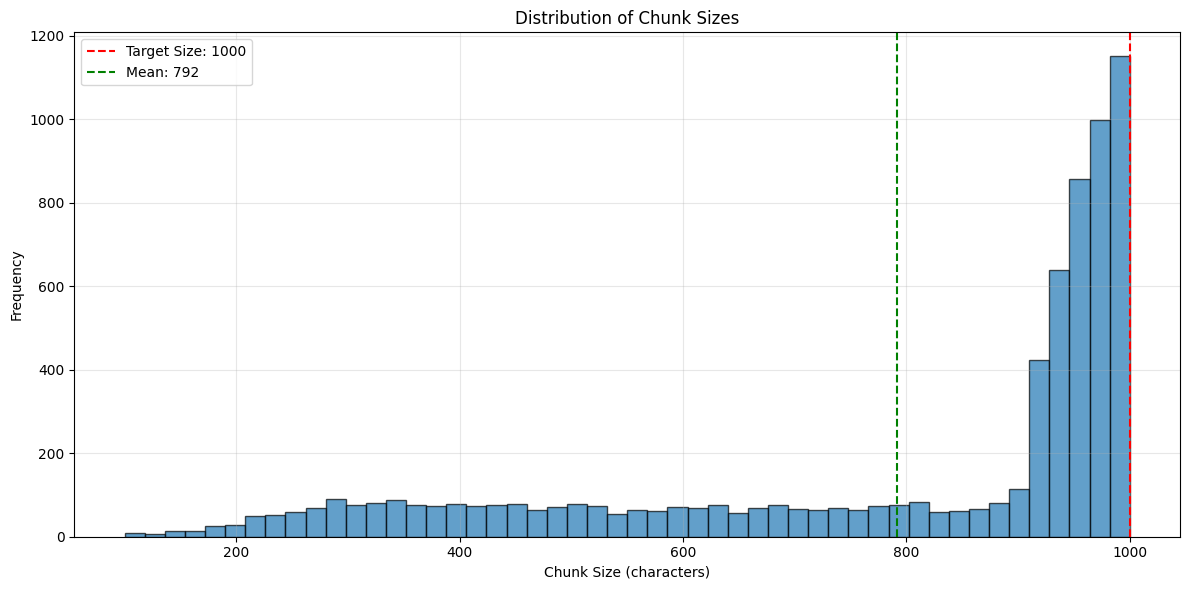


Chunk Size Statistics:
  Min: 100 characters
  Max: 1000 characters
  Mean: 792.0 characters
  Median: 932.0 characters
  Std Dev: 245.9 characters


In [15]:
# Display chunk size distribution
import matplotlib.pyplot as plt
import numpy as np

# Get chunk sizes
chunk_sizes = [chunk['char_count'] for chunk in all_chunks]

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(chunk_sizes, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=CHUNK_SIZE, color='red', linestyle='--', label=f'Target Size: {CHUNK_SIZE}')
plt.axvline(x=np.mean(chunk_sizes), color='green', linestyle='--', label=f'Mean: {np.mean(chunk_sizes):.0f}')
plt.xlabel('Chunk Size (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Chunk Sizes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nChunk Size Statistics:")
print(f"  Min: {min(chunk_sizes)} characters")
print(f"  Max: {max(chunk_sizes)} characters")
print(f"  Mean: {np.mean(chunk_sizes):.1f} characters")
print(f"  Median: {np.median(chunk_sizes):.1f} characters")
print(f"  Std Dev: {np.std(chunk_sizes):.1f} characters")

In [16]:
# Sample: Display a few chunks
print("\n" + "="*80)
print("SAMPLE CHUNKS")
print("="*80)

# Display first 3 chunks
for i, chunk in enumerate(all_chunks[:3], 1):
    print(f"\nChunk {i}:")
    print("-" * 80)
    print(f"ID: {chunk['chunk_id']}")
    print(f"Book: {chunk['book_title']}")
    print(f"Chapter: {chunk['chapter']}")
    print(f"Page: {chunk['page_number']}")
    print(f"Citation: {chunk['citation']}")
    print(f"Size: {chunk['char_count']} chars, {chunk['word_count']} words, ~{chunk['token_count']} tokens")
    print(f"\nText Preview (first 300 characters):")
    print(chunk['text'][:300] + "...")
    print("-" * 80)


SAMPLE CHUNKS

Chunk 1:
--------------------------------------------------------------------------------
ID: 299f007b_p2_c0
Book: AI Engineering
Chapter: Introduction
Page: 2
Citation: [AI Engineering, Introduction, Page 2]
Size: 988 chars, 151 words, ~200 tokens

Text Preview (first 300 characters):
“This book of fers a comprehensive, well-structured guide to the essential
aspects of building generative AI systems. A must-read for any professional
looking to scale AI across the enterprise.”
Vittorio Cretella, former global CIO at P&G and Mars
“Chip Huyen gets generative AI. She is a remarkable ...
--------------------------------------------------------------------------------

Chunk 2:
--------------------------------------------------------------------------------
ID: 299f007b_p2_c1
Book: AI Engineering
Chapter: Introduction
Page: 2
Citation: [AI Engineering, Introduction, Page 2]
Size: 968 chars, 140 words, ~176 tokens

Text Preview (first 300 characters):
tool that anyone can use

## Next Steps

✅ Text chunking complete!

The chunked data is now ready for the next stage:
- **Notebook 3**: Embedding generation and vector database setup

### Output Files Created:
1. `data/chunks/all_chunks.json` - All chunks from all books
2. `data/chunks/[BookTitle]_chunks.json` - Chunks for each individual book

### Chunk Metadata Included:
- `chunk_id`: Unique identifier
- `book_title`: Source book
- `chapter`: Chapter name
- `page_number`: Page number in original PDF
- `text`: Chunk content
- `citation`: Formatted citation string
- Size metrics: character count, word count, token count

### What's Next:
In the next notebook, we will:
1. Load the chunked text data
2. Generate embeddings for each chunk using sentence-transformers
3. Set up ChromaDB vector database
4. Store chunks with embeddings in the database
5. Test similarity search functionality